In [1]:
import os
import random
from pathlib import Path
from collections import defaultdict
import sys
import json

import yaml
import numpy as np
import pandas as pd
import cv2
import spacy
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import softmax
from torch.utils.data import Dataset, DataLoader
import japanese_clip as ja_clip
from transformers import AutoTokenizer
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from PIL import Image
from torchvision.models import ResNet152_Weights
from umap import UMAP
import MeCab

sys.path.append('../')
from src.data.prepare import load_base_df
from src.models.MMBT.dataset import (BokeTextImageDataset, collate_fn)
from src.models.MMBT.mmbt import load_model
from src.models.utils import fix_seed, plot_confusion_matrix

MAX_SEQENCE_LEN = 48

## データ読み込み

In [2]:
train_df, test_df, submission_df = load_base_df('../dataset/csv/', '../dataset/imgs/')

In [3]:
print(f'train_df.shape: {train_df.shape}')
display(train_df.head())

print(f'test_df.shape: {test_df.shape}')
display(test_df.head())

train_df.shape: (24962, 5)


,id,odai_photo_file_name,text,is_laugh,img_path
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0,../dataset/imgs/train/9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0,../dataset/imgs/train/c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0,../dataset/imgs/train/whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0,../dataset/imgs/train/6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0,../dataset/imgs/train/0i9gsa2jsm.jpg


test_df.shape: (6000, 5)


,id,odai_photo_file_name,text,img_path,is_laugh
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ,../dataset/imgs/test/nc1kez326b.jpg,0
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！,../dataset/imgs/test/49xt2fmjw0.jpg,0
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹,../dataset/imgs/test/9dtscjmyfh.jpg,0
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??,../dataset/imgs/test/osa3n56tiv.jpg,0
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...,../dataset/imgs/test/yb1yqs4pvb.jpg,0


## 特徴量抽出

### MMBTの中間層の特徴量抽出

以下のディレクトリ構成で保存する。

```
./dataset
    |_EXPERIMENT_NAME (MMBTなどのモデル学習時の実験名)
        |-1_fold (k-foldそれぞれにおいて作成されたモデル)
        |  |- train.csv (1 fold目の学習に使用されたデータのベクトル。 こちらでパラメータチューニング, 最終的なモデル作成を実施)
        |  |- valid.csv (1 fold目の検証に使用されたデータのベクトル。 train.csvで最終的なモデルを作成し、こちらで評価)
        |  |_ test.csv (結果出力用)
        |
        :
        |_k_fold　(1_foldと同じ構成)
```

学習の流れとしては、下記を想定

foldごとに以下を実施

1. csvに他の特徴量を付与。 ex. text長, 文章中の人物名の数, 画像中の犬と猫の数, 人の数 など。

2. ハイパーパラメータチューニング(train.csvでcross validationして決める)

3. モデル最終化(チューニングしたハイパーパラメータでtrain.csvのデータで学習し、valid.csvでlossなどの評価指標取得。)

4. test.csvを予測

その後、モデルごとのtest.csvの予測結果の平均を提出


In [4]:
def vectorize_ds(model, dataloader, device):
    model = model.to(device)
    vector = []
    for ds in tqdm(dataloader):
        ds = {k: v.to(device) for k, v in ds.items()}
        with torch.no_grad():
            # 最終隠れ層の始まりの文字のベクトルを取得して、特徴量として用いる。
            hidden_states = model(**ds).hidden_states[-1][:, 0]
            # numpy arrayにする。
            hidden_states = hidden_states.cpu().detach().numpy() if torch.cuda.is_available() else hidden_states.cpu().numpy()
            vector.append(hidden_states)
    return np.concatenate(vector)


def load_validate_model(src):
    model = load_model(output_hidden_states=True)
    model.load_state_dict(torch.load(src))
    return model

In [5]:
# 定数定義
EXPERIMENT_NAME = '5fold_stratified_mmbt_seed_0'
VECTOR_COL_PREFIX = 'mmbt_vector'
ID_COL = 'id'

# cpu or gpuを取得
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# tokenizer取得
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

# 保存済みのモデルパス一覧取得
MODEL_SRC_BASE = Path(f'../model/{EXPERIMENT_NAME}/')
MODEL_SRC_LIST = [
    MODEL_SRC_BASE / 'fold_1/checkpoint-225/pytorch_model.bin',
    MODEL_SRC_BASE / 'fold_2/checkpoint-175/pytorch_model.bin',
    MODEL_SRC_BASE / 'fold_3/checkpoint-250/pytorch_model.bin',
    MODEL_SRC_BASE / 'fold_4/checkpoint-250/pytorch_model.bin',
    MODEL_SRC_BASE / 'fold_5/checkpoint-175/pytorch_model.bin'
]
# 対応する検証データのインデックスを保存したログがあるディレクトリを定義
LOG_DIR = Path('../results/5fold_stratified_mmbt_seed_0/')
# 保存先定義
DST_ROOT = Path(f'../dataset/processed/{EXPERIMENT_NAME}')
# testデータローダー定義
test_ds = BokeTextImageDataset(test_df, tokenizer, MAX_SEQENCE_LEN, image_transform=ResNet152_Weights.IMAGENET1K_V2)
test_dl = DataLoader(test_ds, batch_size=12, collate_fn=collate_fn, shuffle=False)

for i, model_src in enumerate(MODEL_SRC_LIST):
    assert model_src.exists(), '読み込み対象のモデルパスがあること'
    relpath = os.path.relpath(model_src, MODEL_SRC_BASE)
    fold_name = relpath.split(os.sep)[0]
    log_file_path = LOG_DIR / f'{fold_name}_log.json'
    assert log_file_path.exists(), '検証データインデックス取得用のjsonが存在すること'
    with open(log_file_path, 'r') as f:
        data = json.load(f)
        train_idx = data['train_idx']
        valid_idx = data['valid_idx']
    # ベクトル化
    target_ds = BokeTextImageDataset(train_df, tokenizer, MAX_SEQENCE_LEN, image_transform=ResNet152_Weights.IMAGENET1K_V2)
    target_dl = DataLoader(target_ds, batch_size=12, collate_fn=collate_fn, shuffle=False)
    model = load_validate_model(model_src)
    model.to(device)
    model.eval()
    train_hidden_vector = vectorize_ds(model, target_dl, device)
    test_hidden_vector = vectorize_ds(model, test_dl, device)
    # csvに保存
    dst_dir = DST_ROOT / fold_name
    if not dst_dir.exists():
        dst_dir.mkdir(parents=True)
    train_vector_df = pd.DataFrame(train_hidden_vector[train_idx]).add_prefix(VECTOR_COL_PREFIX)
    train_vector_df[ID_COL] = train_df.iloc[train_idx][ID_COL].to_list()
    train_vector_df.to_csv(str(dst_dir / 'train.csv'), index=False)
    valid_vector_df = pd.DataFrame(train_hidden_vector[valid_idx]).add_prefix(VECTOR_COL_PREFIX)
    valid_vector_df[ID_COL] = train_df.iloc[valid_idx][ID_COL].to_list()
    valid_vector_df.to_csv(str(dst_dir / 'valid.csv'), index=False)
    test_vector_df = pd.DataFrame(test_hidden_vector).add_prefix(VECTOR_COL_PREFIX)
    test_vector_df[ID_COL] = test_df[ID_COL]
    test_vector_df.to_csv(str(dst_dir / 'test.csv'), index=False)
    
    print(f'{i + 1} / {len(MODEL_SRC_LIST)} finisied')

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

1 / 5 finisied


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

2 / 5 finisied


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

3 / 5 finisied


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

4 / 5 finisied


Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2081 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

5 / 5 finisied


In [25]:
train_dataloader = DataLoader(train_ds, batch_size=12, collate_fn=collate_fn, shuffle=False)
train_vector = vectorize_ds(model, train_dataloader, device)
train_vector_df = pd.DataFrame(train_vector).add_prefix('mmbt_vector')
train_vector_df['id'] = train_df['id']
train_vector_df['is_laugh'] = train_df['is_laugh']
train_vector_df.to_csv('../dataset/processed/train_mmbt.csv', index=False)

In [26]:
test_dataloader = DataLoader(test_ds, batch_size=12, collate_fn=collate_fn, shuffle=False)
test_vector = vectorize_ds(model, test_dataloader, device)
test_vector_df = pd.DataFrame(test_vector).add_prefix('mmbt_vector')
test_vector_df['id'] = test_df['id']
test_vector_df['is_laugh'] = test_df['is_laugh']
test_vector_df.to_csv('../dataset/processed/test_mmbt.csv', index=False)

#### 抽出した中間層特徴量をumapで可視化(fold_1)

重なりが多いが、分離可能な範囲もある。

- x軸の左半分において、0と1がある程度分離している(右半分に比べて)

In [11]:
plot_df = pd.read_csv(str(DST_ROOT / 'fold_1' / 'valid.csv'))
id_laugh_merged_df = plot_df.merge(train_df[['id', 'is_laugh']], on='id')
X_scaled = MinMaxScaler().fit_transform(plot_df.drop(columns=['id']))
mapper = UMAP(n_components=2, metric='cosine', random_state=0, verbose=1).fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['x', 'y'])
df_emb['is_laugh'] = id_laugh_merged_df['is_laugh']
df_emb.head()

UMAP(angular_rp_forest=True, metric='cosine', random_state=0, verbose=1)
Mon Sep 26 22:50:08 2022 Construct fuzzy simplicial set
Mon Sep 26 22:50:08 2022 Finding Nearest Neighbors
Mon Sep 26 22:50:08 2022 Building RP forest with 9 trees
Mon Sep 26 22:50:08 2022 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	Stopping threshold met -- exiting after 5 iterations
Mon Sep 26 22:50:08 2022 Finished Nearest Neighbor Search
Mon Sep 26 22:50:08 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Sep 26 22:50:18 2022 Finished embedding


,x,y,is_laugh
0,-1.942663,8.261619,0
1,0.518040,10.502784,0
2,-1.651679,8.544156,0
3,-2.902241,7.034550,0
4,-5.052710,4.958746,1


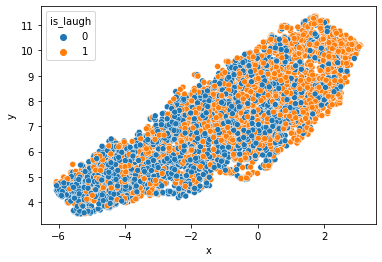

In [12]:
sns.scatterplot(data=df_emb, x='x', y='y', hue='is_laugh')
plt.show()

## テキスト長の特徴量追加

In [54]:
TEXT_LEN_COL = 'text_len'
train_txt_len_df = pd.DataFrame({
    TEXT_LEN_COL: train_df['text'].str.len(),
    'id': train_df['id']
})
test_txt_len_df = pd.DataFrame({
    TEXT_LEN_COL: test_df['text'].str.len(),
    'id': test_df['id']
})
train_txt_len_df.to_csv('../dataset/processed/train_text_len.csv', index=False)
test_txt_len_df.to_csv('../dataset/processed/test_text_len.csv', index=False)

## CLIPによる画像とテキスト間の類似度特徴量追加

分布から、あまり有効な特徴量とはならないかと思われる

In [36]:
class CLIPDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, image_preprocess, device, max_seq_len=MAX_SEQENCE_LEN):
        self.df = df
        self.tokenizer = tokenizer
        self.image_preprocess = image_preprocess
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        encodings = ja_clip.tokenize(
            texts=[row['text']],
            max_seq_len=self.max_seq_len,
            tokenizer=self.tokenizer,
            device=device
        )
        image = Image.open(row['img_path'])
        image = self.image_preprocess(image).to(device)
        return encodings, image

def collate_fn(batch):
    encodings = defaultdict(list)
    images = []
    for element in batch:
        for key, val in element[0].items():
            encodings[key].append(val)
        images.append(element[1])
    encodings = {key: torch.concat(val) for key, val in encodings.items()}
    images = torch.stack(images)
    return encodings, images


def similarity_arr_with_clip(model, dl: DataLoader):
    result = []
    for ds in tqdm(dl):
        image_features = model.get_image_features(ds[1])
        text_features = model.get_text_features(**ds[0])
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        # 他の画像の説明文との類似度は不要なので対角成分のみ取得
        similarity_arr = torch.diag(image_features @ text_features.T)
        similarity_arr = similarity_arr.cpu().detach().numpy() if torch.cuda.is_available() else similarity_arr.cpu().numpy()
        result.append(similarity_arr)
    return np.concatenate(result)

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = ja_clip.load("rinna/japanese-clip-vit-b-16", cache_dir="/tmp/japanese_clip", device=device)
model.eval()
tokenizer = ja_clip.load_tokenizer()

In [56]:
train_clip_ds = CLIPDataset(train_df, tokenizer, preprocess, device)
train_clip_dl = DataLoader(train_clip_ds, batch_size=12, collate_fn=collate_fn)
train_similarity_arr = similarity_arr_with_clip(model, train_clip_dl)

train_similarity_df = pd.DataFrame({
    'similarity': train_similarity_arr,
    'id': train_df['id']
})
train_similarity_df.to_csv('../dataset/processed/train_similarity.csv', index=False)

  0%|          | 0/2081 [00:00<?, ?it/s]

In [57]:
train_similarity_df['is_laugh'] = train_df['is_laugh']

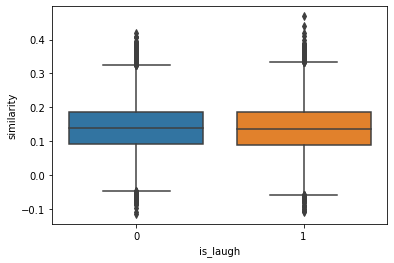

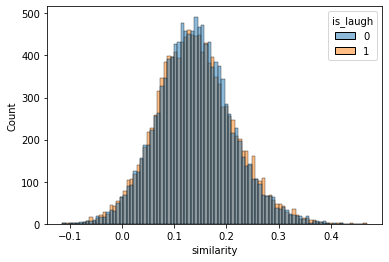

In [58]:
sns.boxplot(data=train_similarity_df, x='is_laugh', y='similarity')
plt.show()
sns.histplot(data=train_similarity_df, x='similarity', hue='is_laugh')
plt.show()

In [59]:
test_clip_ds = CLIPDataset(test_df, tokenizer, preprocess, device)
test_clip_dl = DataLoader(test_clip_ds, batch_size=12, collate_fn=collate_fn)
test_similarity_arr = similarity_arr_with_clip(model, test_clip_dl)

test_similarity_df = pd.DataFrame({
    'similarity': test_similarity_arr,
    'id': test_df['id']
})
test_similarity_df.to_csv('../dataset/processed/test_similarity.csv', index=False)

  0%|          | 0/500 [00:00<?, ?it/s]

## TF-IDF特徴量

各文章のTF-IDFベクトルの最大値、平均を特徴量する。

In [3]:
class MecabTokenizer:
    def __init__(self, wakati):
        self.wakati = wakati

    def __call__(self, text):
        return self.wakati.parse(text).split()


def extract_tfidf_static_info(tfidf_vector):
    result = {
        'tfidf_mean': [],
        'tfidf_max': [],
        'tfidf_std': [],
        'tfidf_min': []
    }
    for v in tqdm(tfidf_vector, total=tfidf_vector.shape[0]):
        result['tfidf_mean'].append(v.toarray().mean())
        result['tfidf_max'].append(v.toarray().max())
        result['tfidf_std'].append(v.toarray().std())
        result['tfidf_min'].append(v.toarray().min())
    return result

In [5]:
mecab_tokenizer = MecabTokenizer(MeCab.Tagger('-Owakati'))
tfidf = TfidfVectorizer(tokenizer=mecab_tokenizer)
train_txts = train_df['text'].values
train_vector = tfidf.fit_transform(train_txts)

In [6]:
test_txts = test_df['text'].values
test_vector = tfidf.transform(test_txts)

  0%|          | 0/24962 [00:00<?, ?it/s]

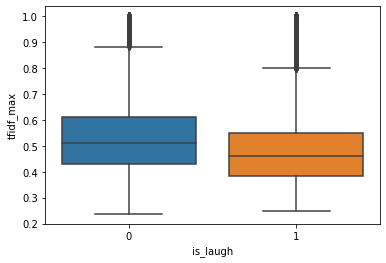

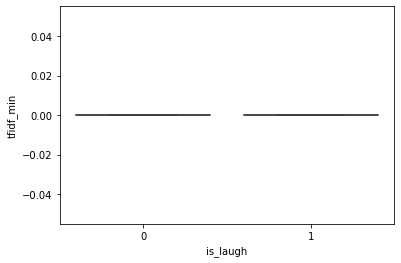

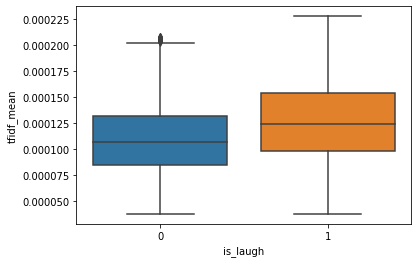

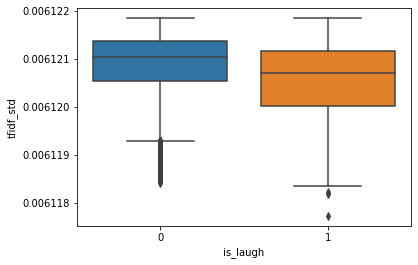

In [7]:
# 学習データで分布を確認
train_tfidf_df = pd.DataFrame(extract_tfidf_static_info(train_vector))
plot_df = train_tfidf_df.copy()
plot_df['is_laugh'] = train_df['is_laugh']
y_cols = ['tfidf_max', 'tfidf_min', 'tfidf_mean', 'tfidf_std']
for y_col in y_cols:
    sns.boxplot(data=plot_df, x='is_laugh', y=y_col)
    plt.show()

In [8]:
train_tfidf_df = pd.DataFrame(extract_tfidf_static_info(train_vector))
train_tfidf_df['id'] = train_df['id']
train_tfidf_df = train_tfidf_df.drop(columns=['tfidf_min'])
train_tfidf_df.to_csv('../dataset/processed/train_tfidf_vector.csv', index=False)

test_vector_df = pd.DataFrame(extract_tfidf_static_info(test_vector))
test_vector_df['id'] = test_df['id']
test_vector_df = test_vector_df.drop(columns=['tfidf_min'])
test_vector_df.to_csv('../dataset/processed/test_tfidf_vector.csv', index=False)

  0%|          | 0/24962 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

## 固有表現抽出

In [27]:
class ExtractPersonApearInTxt:
    def __init__(self, nlp=None):
        self.nlp = nlp if nlp is not None else spacy.load('ja_ginza_electra')

    def __call__(self, texts):
        docs = self.nlp.pipe(texts)
        n_texts = len(texts)
        results = [0] * n_texts
        for i, doc in enumerate(tqdm(docs, total=n_texts)):
            for ent in doc.ents:
                if ent.label_ == 'Person':
                    results[i] = 1
        return results

In [28]:
nlp = spacy.load('ja_ginza_electra')

In [29]:
extract_person_apear = ExtractPersonApearInTxt()
train_has_person_list = extract_person_apear(train_df['text'].values.tolist())
test_has_person_list = extract_person_apear(test_df['text'].values.tolist())

  0%|          | 0/24962 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

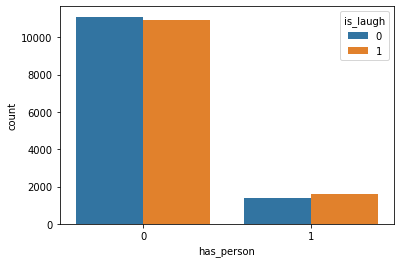

In [30]:
plot_df = pd.DataFrame({'has_person': train_has_person_list, 'is_laugh': train_df['is_laugh'].to_list()})
sns.countplot(data=plot_df, x='has_person', hue='is_laugh')
plt.show()

In [32]:
np.unique(train_has_person_list, return_counts=True)

(array([0, 1]), array([21993,  2969]))

In [31]:
np.unique(test_has_person_list, return_counts=True)

(array([0, 1]), array([5270,  730]))

In [33]:
train_has_person_df = pd.DataFrame({'id': train_df['id'], 'has_person': train_has_person_list})
train_has_person_df.to_csv('../dataset/processed/train_has_person.csv', index=False)
test_has_person_df = pd.DataFrame({'id': test_df['id'], 'has_person': test_has_person_list})
test_has_person_df.to_csv('../dataset/processed/test_has_person.csv', index=False)

## 物体検知で写っている物体数を特徴量にする

- データセット: coco https://raw.githubusercontent.com/ultralytics/yolov5/master/data/coco.yaml

- model: yolov5 https://docs.ultralytics.com/tutorials/pytorch-hub/

In [6]:
class ExtractNumObjectInImage:
    def __init__(self, model=None, coco_yml_path: str='../third_party/coco.yaml', prefix='_counts'):
        self.model = model if model is not None else torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
        self.model.eval()
        self.idx2label = self._load_yml(coco_yml_path)
        self.prefix = '_counts'

    @staticmethod
    def _load_yml(yml_path: str):
        with open(yml_path, 'r') as f:
            coco = yaml.safe_load(f)
        return coco['names']

    def _label_count_dict_for_one_image(self, result):
        labels, counts = np.unique(result, return_counts=True)
        results = {f'{label}{self.prefix}': 0 for label in self.idx2label.values()}
        for idx, count in zip(labels, counts):
            label = f'{self.idx2label[idx]}{self.prefix}'
            results[label] = count
        return results

    def __call__(self, dl: DataLoader) -> pd.DataFrame:
        result_df_base = []
        for ds in tqdm(dl, total=len(dl)):
            preds = self.model(ds)
            for pred in preds.xyxy:
                labels_in_img = pred.cpu().detach().numpy() if torch.cuda.is_available() else preds.cpu().numpy()
                label_dict = self._label_count_dict_for_one_image(labels_in_img[:, -1])
                result_df_base.append(label_dict)
        return pd.DataFrame(result_df_base)


class ObjectDetectionDataSet(Dataset):
    def __init__(self, img_path_list):
        self.img_path_list = img_path_list
    
    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, index):
        return self.img_path_list[index]

In [7]:
BATCH_SIZE = 32
# 学習用データのcsv化
extract_num_object_in_img = ExtractNumObjectInImage()
train_od_dl = DataLoader(ObjectDetectionDataSet(train_df['img_path'].to_list()), batch_size=BATCH_SIZE)
train_od_df = extract_num_object_in_img(train_od_dl)
train_od_df['id'] = train_df['id']
train_od_df.to_csv('../dataset/processed/train_od_counts.csv', index=False)

# テスト用データのcsv化
test_od_dl = DataLoader(ObjectDetectionDataSet(test_df['img_path'].to_list()), batch_size=BATCH_SIZE)
test_od_df = extract_num_object_in_img(test_od_dl)
test_od_df['id'] = test_df['id']
test_od_df.to_csv('../dataset/processed/test_od_counts.csv', index=False)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: YOLOv5 requirement "tqdm>=4.64.0" not found, attempting AutoUpdate...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-9-29 Python-3.7.13 torch-1.12.0 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 7974MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


  0%|          | 0/781 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]